# **Emotion Peaks PLS**

This notebook is for the analysis of the data that are produced from peaks_PLS.py. 

In [423]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Counting points function is used to count the number of peaks in each emotion.

In [424]:
emotions = ['Happiness', 'Sad', 'Anxiety', 'Love', 'Fear', 'WarmHeartedness', 'Regard']
movies = ['Sintel', 'TearsOfSteel', 'Superhero', 'TheSecretNumber']
thresholds = [1, 1.5, 2]

def counting_points(movies, thresholds, emotions):
    """This function is used to count the number of points for each emotion in each movie."""
    count_pts = {}

    for movie in movies:
        count_pts[movie] = {}
        
        for thr in thresholds:
            count_pts[movie][thr] = {}

            # Reading the data
            labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
            data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
            data.columns = labels['Columns']
            
            # Counting the number of points for each emotion
            for emotion in emotions:
                if emotion == 'Regard':
                    print(movie)
                    print(len(data[data[emotion] > thr]))
                number_points = len(data[data[emotion] > thr])
                count_pts[movie][thr][emotion] = number_points
            
            count_pts[movie][thr]['All Movie'] = len(data)
    return count_pts

count_pts = counting_points(movies, thresholds, emotions)

print(count_pts)

Sintel
306
Sintel
218
Sintel
33
TearsOfSteel
0
TearsOfSteel
0
TearsOfSteel
0
Superhero
119
Superhero
39
Superhero
1
TheSecretNumber
0
TheSecretNumber
0
TheSecretNumber
0
{'Sintel': {1: {'Happiness': 71, 'Sad': 117, 'Anxiety': 117, 'Love': 0, 'Fear': 94, 'WarmHeartedness': 83, 'Regard': 306, 'All Movie': 555}, 1.5: {'Happiness': 54, 'Sad': 98, 'Anxiety': 84, 'Love': 0, 'Fear': 70, 'WarmHeartedness': 79, 'Regard': 218, 'All Movie': 555}, 2: {'Happiness': 31, 'Sad': 88, 'Anxiety': 51, 'Love': 0, 'Fear': 58, 'WarmHeartedness': 49, 'Regard': 33, 'All Movie': 555}}, 'TearsOfSteel': {1: {'Happiness': 39, 'Sad': 0, 'Anxiety': 82, 'Love': 24, 'Fear': 75, 'WarmHeartedness': 35, 'Regard': 0, 'All Movie': 452}, 1.5: {'Happiness': 20, 'Sad': 0, 'Anxiety': 36, 'Love': 0, 'Fear': 11, 'WarmHeartedness': 19, 'Regard': 0, 'All Movie': 452}, 2: {'Happiness': 0, 'Sad': 0, 'Anxiety': 3, 'Love': 0, 'Fear': 0, 'WarmHeartedness': 8, 'Regard': 0, 'All Movie': 452}}, 'Superhero': {1: {'Happiness': 56, 'Sad': 28

In [425]:
emo_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_withcontrol_results.csv')
thr_1_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks.csv')
thr_1_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
thr_1_data['threshold'] = 1
thr_1_data.rename(columns={'emotion':'Emotion'}, inplace=True)
emo_data = pd.concat([emo_data, thr_1_data])
emo_data.dropna(inplace=True)
emo_data.head()

,Covariance Explained,P-value,Movie,LC,Region,bootstrap_round,Emotion,threshold
0,0.395432,0.002997,Sintel,1,ALL,0,Happiness,1.5
1,0.207847,0.027972,Sintel,2,ALL,0,Happiness,1.5
2,0.164799,0.109890,Sintel,3,ALL,0,Happiness,1.5
3,0.077500,0.024975,Sintel,4,ALL,0,Happiness,1.5
4,0.057993,0.052947,Sintel,5,ALL,0,Happiness,1.5


In [426]:
# list of the movies that were done
movies = emo_data['Movie'].unique()
emotions_control = emo_data['Emotion'].unique()
emotions = [x for x in emotions_control if not x.startswith('Control')]
thresholds = emo_data['threshold'].unique()

In [427]:
df_bootstrap = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])

df_all_fn = pd.DataFrame()
PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_bold_ALL_bootstrap_results.csv'
df = pd.read_csv(PATH, index_col=0).reset_index()
df['Region'] = 'ALL'
n_movies = df.Movie.unique()
a = np.repeat(np.arange(1,101), 12)
for i in range(n_movies.shape[0]-1):
    a = np.concatenate((a, np.repeat(np.arange(1,101), 12)), axis = 0)
df['bootstrap_round'] = a
df['emotion'] = 'All movie'

df_all = pd.concat([df_all_fn, df], ignore_index=True)

df_all.to_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_{method}_ALL_fn_bootstrap_results.csv')

In [428]:
import seaborn as sns

# Set the control set when the emotion starts with Control
all_emo_control = emo_data[emo_data['Emotion'].apply(lambda x: x.split('_')[0] == 'Control')]

only_whole = True
data_all_movie = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_bold_all_fn_bootstrap_results.csv')

if only_whole:
    all_emo_data = emo_data[emo_data['Region'] == 'ALL']
    all_emo_control = all_emo_control[all_emo_control['Region'] == 'ALL']
    df_all = df_all[df_all['Region'] == 'ALL']
    data_all_movie = data_all_movie[data_all_movie['Region'] == 'ALL']

data_all_movie.rename(columns={'emotion': 'Emotion'}, inplace=True)
data_all_movie.drop(['Unnamed: 0'], axis = 1, inplace = True)
data_all_movie.head()

,Covariance Explained,P-value,Movie,LC,Region,bootstrap_round,Emotion
0,0.409716,0.190809,AfterTheRain,1,ALL,1,All movie
1,0.238667,0.015984,AfterTheRain,2,ALL,1,All movie
2,0.122707,0.480519,AfterTheRain,3,ALL,1,All movie
3,0.081623,0.614386,AfterTheRain,4,ALL,1,All movie
4,0.044830,0.500500,AfterTheRain,5,ALL,1,All movie


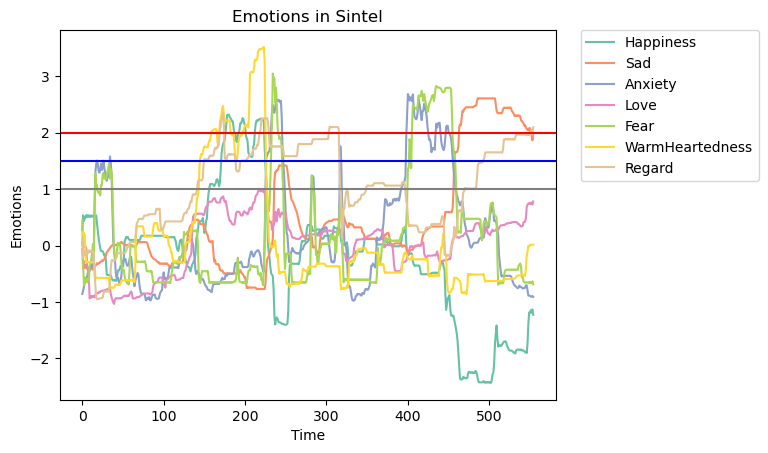

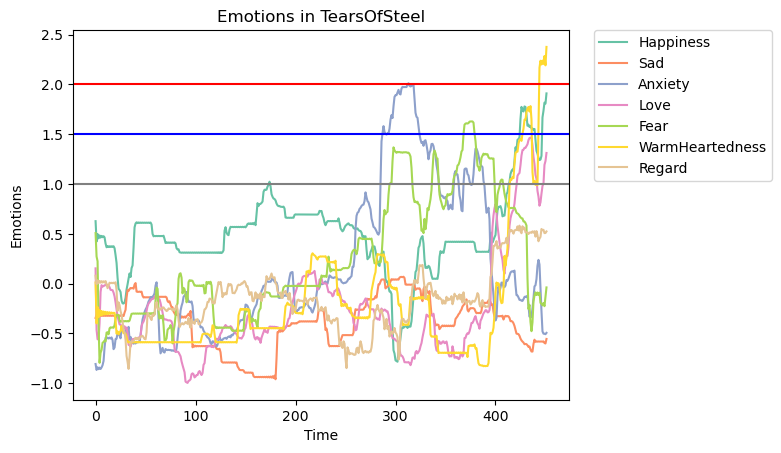

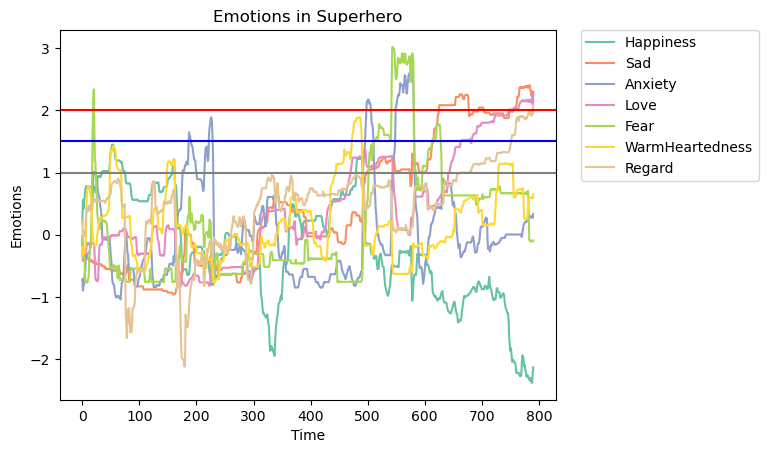

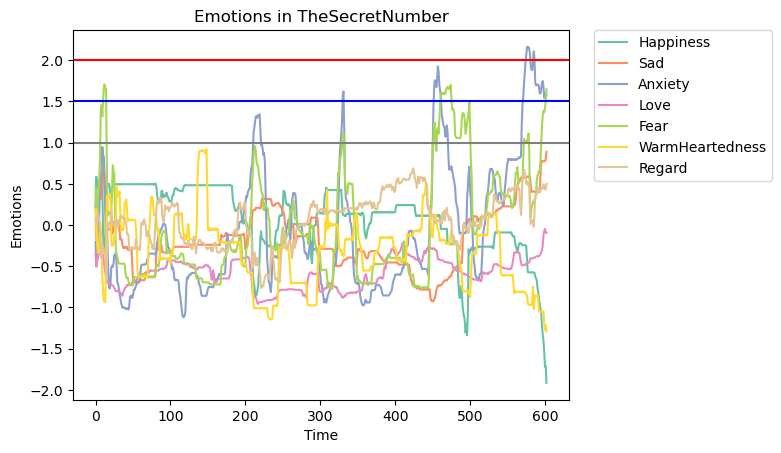

In [429]:
# plot the lineplot
for movie in movies:

    # Reading the data
    labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
    data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
    data.columns = labels['Columns']

    for i, emotion in enumerate(emotions):
        plt.plot(data[emotion], label = emotion, color = palette[list(emotions).index(emotion)])

    plt.title(f'Emotions in {movie}')
    plt.xlabel('Time')
    plt.ylabel('Emotions')
    plt.axhline(y=1, color='grey', linestyle='-')
    plt.axhline(y=2, color='red', linestyle='-')
    plt.axhline(y=1.5, color='blue', linestyle='-')
    # legend on the left
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

In [435]:
labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.154362,0.293594,0.237204,0.313233,-0.387234,0.065398,-0.230856,-0.018541,-0.497117,-0.333071,...,0.375356,0.279738,0.439470,0.113759,-0.858938,0.227151,0.158943,-0.171178,0.062074,-0.061992
1,0.327986,0.520250,0.115551,0.355432,-0.388517,0.026679,-0.550236,-0.071527,-0.428200,-0.283744,...,0.163034,0.536589,-0.326975,-0.215097,-0.800744,0.245169,0.384846,-0.211061,-0.044548,-0.408884
2,0.429627,0.422776,0.301007,0.114038,-0.389238,0.016673,-0.462250,-0.032404,-0.455593,-0.402797,...,-0.214327,0.433103,-0.705494,-0.087566,-0.728802,0.252274,0.301659,-0.215723,-0.011649,-0.277060
3,0.361525,0.430372,0.370608,0.150386,-0.388151,-0.002984,-0.524254,-0.066913,-0.438372,-0.478146,...,-0.493684,0.500108,-0.570978,-0.165500,-0.646097,0.239025,0.349720,-0.199803,-0.025129,-0.393306
4,0.360043,0.393882,0.386739,0.122069,-0.389504,0.048636,-0.474614,-0.035649,-0.451156,-0.531497,...,-0.603083,0.491649,-0.657261,-0.109549,-0.575593,0.255212,0.317174,-0.220420,-0.019355,-0.346459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0.343892,-1.267353,0.793614,-1.407507,-0.451019,0.103974,1.255273,1.915322,-0.892816,-0.881282,...,-0.592812,-1.194310,-0.661526,1.987059,-0.893410,-0.499746,-1.209674,0.744636,0.758053,2.084135
551,0.349402,-1.207763,1.024882,-0.960768,-0.450922,0.109623,0.608191,1.277669,-0.883916,-0.900028,...,-0.576758,-1.147845,-0.644973,1.976601,-0.905361,-0.495111,-1.169380,0.753068,0.735069,1.989777
552,0.344283,-1.195146,1.121321,-0.723925,-0.432689,0.137630,0.369862,0.600566,-0.895303,-0.968635,...,-0.598481,-1.189460,-0.667897,2.049417,-0.907331,-0.379896,-1.219195,0.530802,0.763171,1.953955
553,0.309937,-1.136989,1.077176,-0.660269,-0.386912,0.271796,0.445258,0.417850,-0.879429,-0.965004,...,-0.566550,-1.132539,-0.634154,1.965498,-0.894555,-0.037471,-1.153924,0.234951,0.726398,1.866200


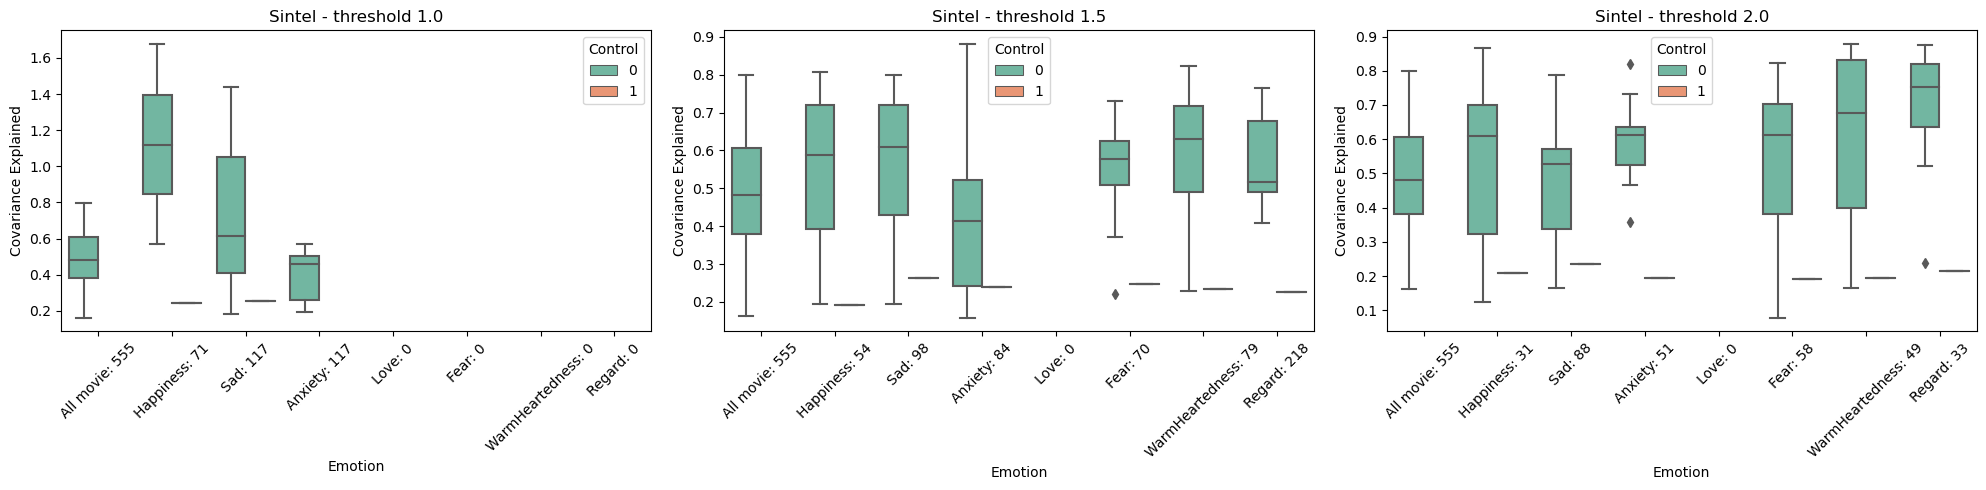

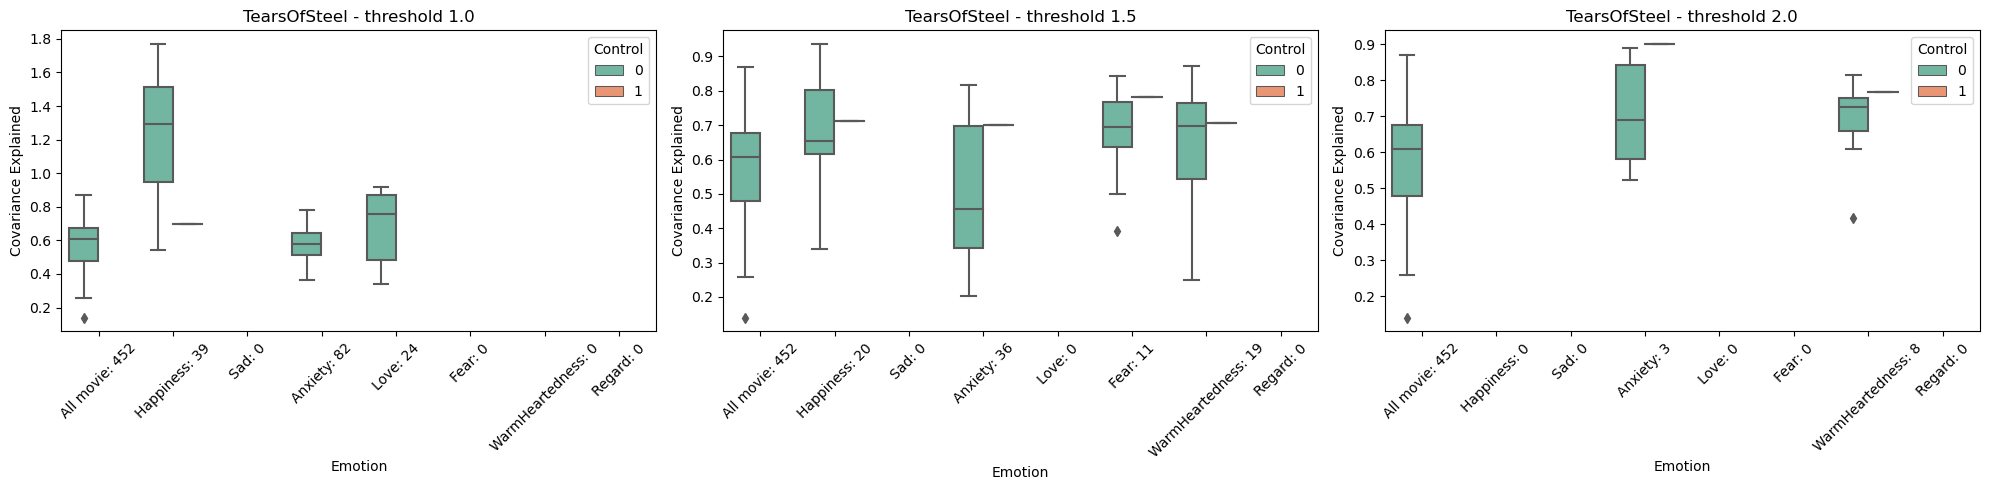

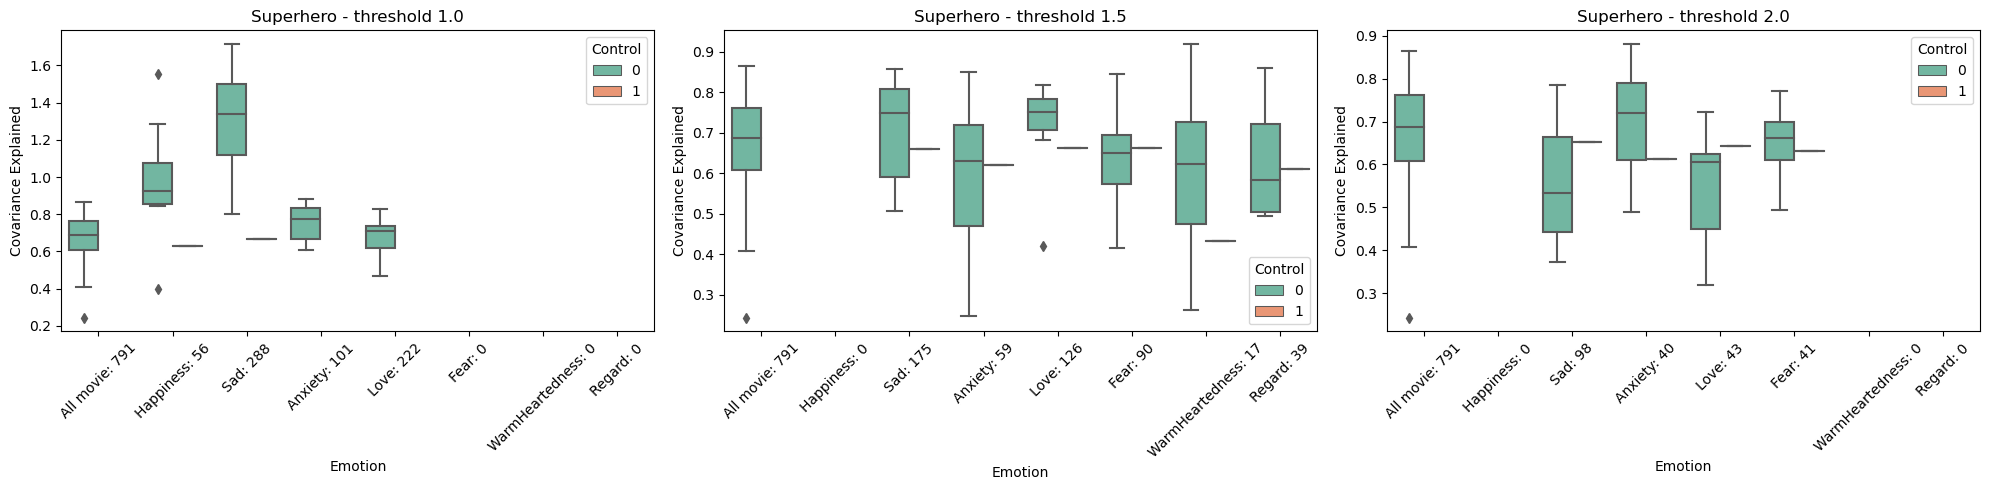

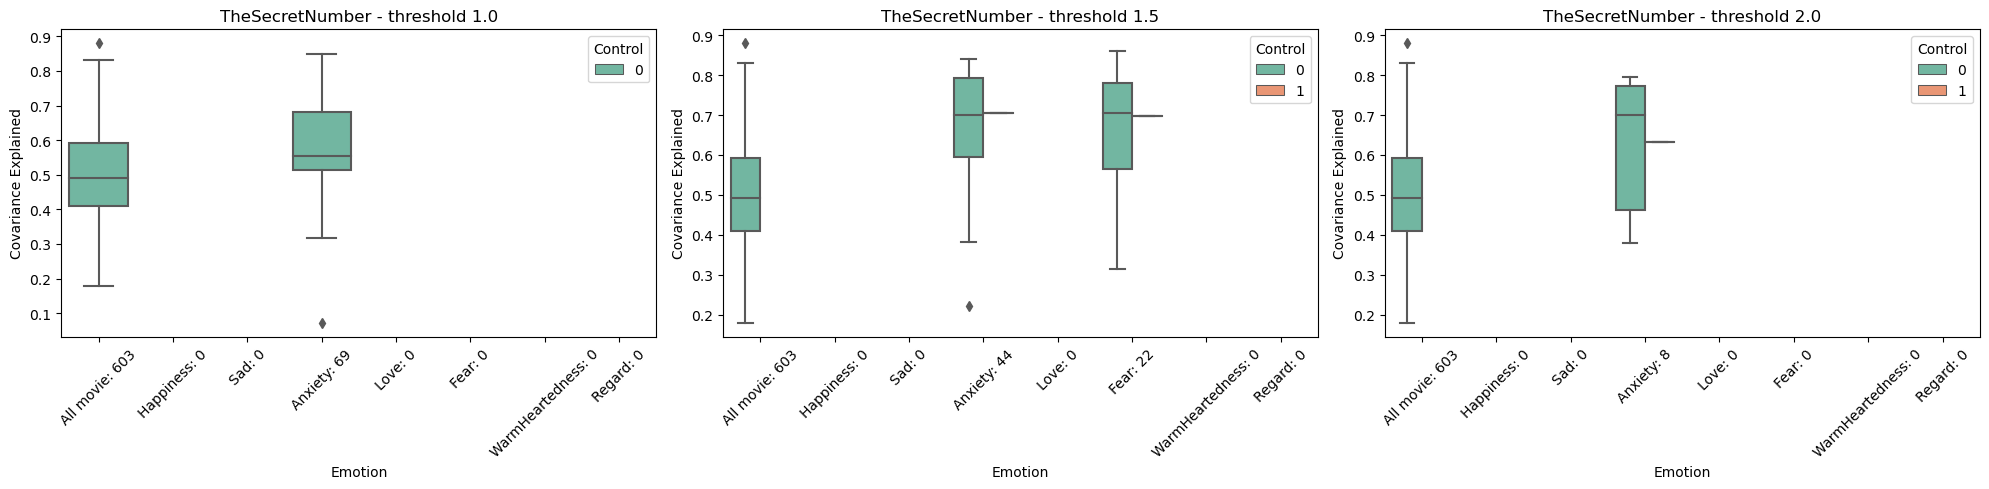

In [430]:
movie = 'Sintel'
thresholds = [1, 1.5, 2]

def retrieve_significant_data(movie, all_emo_data, data_all_movie, count_pts, thresholds, emotions):

    # read the emotion data columns:        Movie Region bootstrap_round emotion Covariance Explained
    data_emo = all_emo_data
    significant = data_emo[data_emo['P-value'] < 0.05]
    significant = significant.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion', 'threshold']).sum()['Covariance Explained'].reset_index()
    significant['Control'] = significant['Emotion'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
    significant['Emotion'] = significant['Emotion'].apply(lambda x: x.split('_')[-1])

    # significant all movie
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()
    significant_all_movie['Control'] = 0

    # merge the three dataframes
    significant = pd.concat([significant, significant_all_movie], ignore_index=True)
    significant = significant[significant['Movie'] == movie]

    for emotion in emotions:
        for thr in thresholds:
            significant.loc[(significant['Emotion'] == emotion.split('_')[-1]) & (significant['threshold'] == thr), 'Number of points'] = count_pts[movie][thr][emotion]
    significant.loc[significant['Emotion'] == 'All movie', 'Number of points'] = count_pts[movie][thr]['All Movie']
    return significant

def plot_peaks(movie, significant, data, emotions, thresholds):
    # Define your thresholds
    thresholds = [1.0, 1.5, 2.0]  # Example thresholds
    palette = sns.color_palette("Set2", 8)

    # Assuming 'significant' is your DataFrame and 'emotions' is defined
    order_emotions = ['All movie'] + emotions  # Adjusted for simplicity

    # Set up the subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))  # Adjust the size as needed

    for i, thr in enumerate(thresholds):
        # Filter data for the current threshold
        significant.loc[significant['Emotion'] == 'All movie', 'threshold'] = thr
        df_thr = significant[significant['threshold'] == thr]

        # Plot the boxplot in the i-th subplot
        sns.boxplot(x='Emotion', y='Covariance Explained', data=df_thr,  hue='Control',
                    palette=palette, order=order_emotions, ax=axes[i])

        # Adjust x-ticks
        list_n = []
        for emo in order_emotions:
            n = df_thr[df_thr['Emotion'] == emo.split('_')[0]]['Number of points'].unique()
            if len(n) == 0:
                n = 0
            else:
                n = n[0]
            list_n.append(f'{emo}: {int(n)}')

        axes[i].set_xticklabels(list_n, rotation=45)
        axes[i].set_title(f'{movie} - threshold {thr}')


    plt.tight_layout()
    plt.show()

for movie in movies:
    significant = retrieve_significant_data(movie, all_emo_data, data_all_movie, count_pts, thresholds, emotions)
    plot_peaks(movie, significant, data, emotions, thresholds)

## mean values

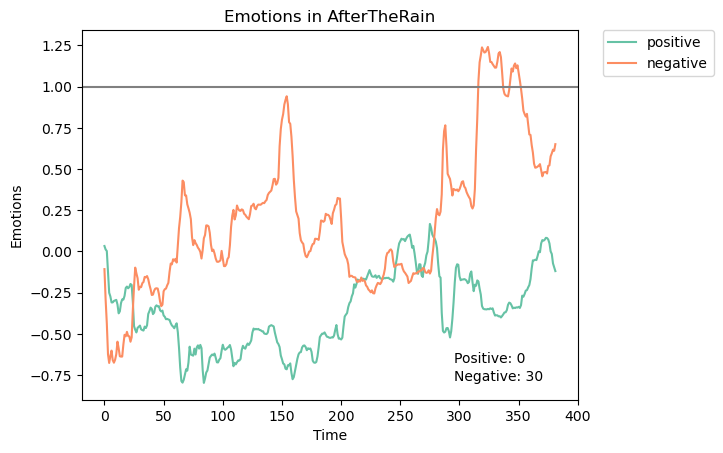

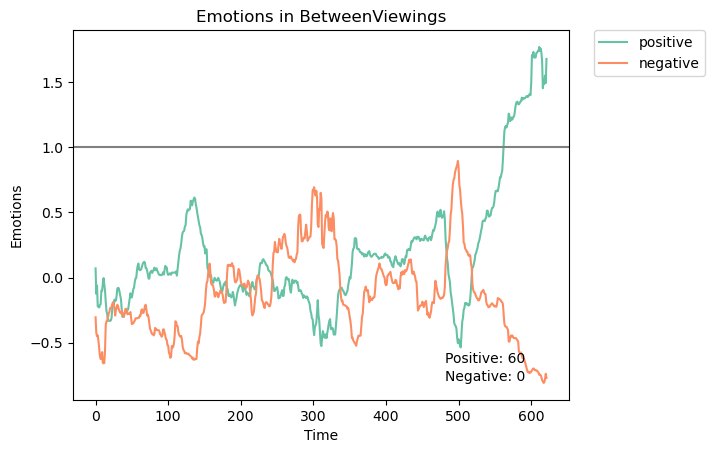

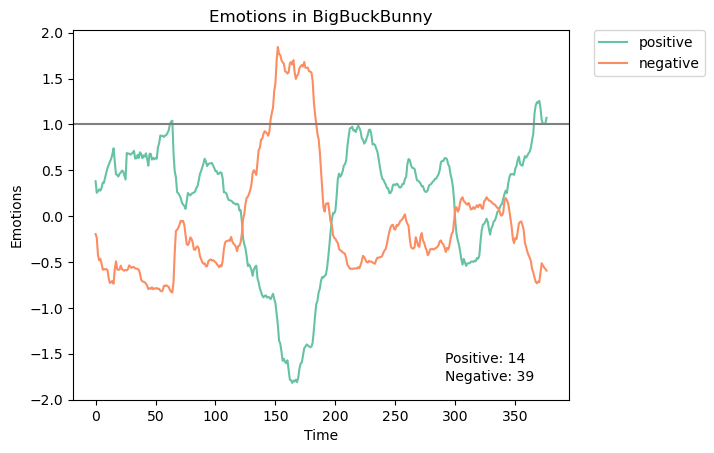

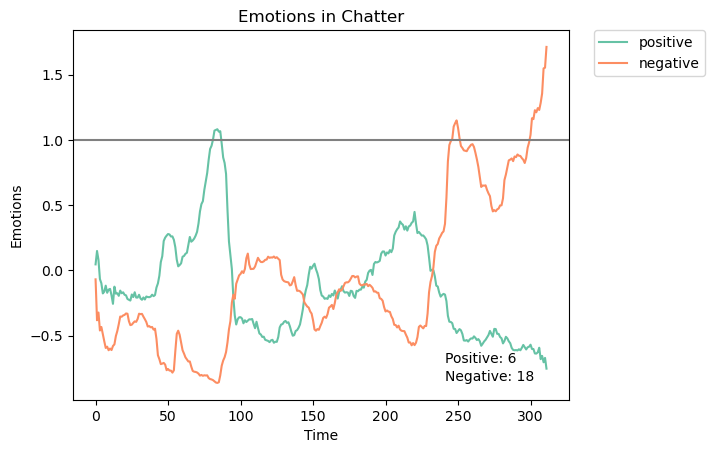

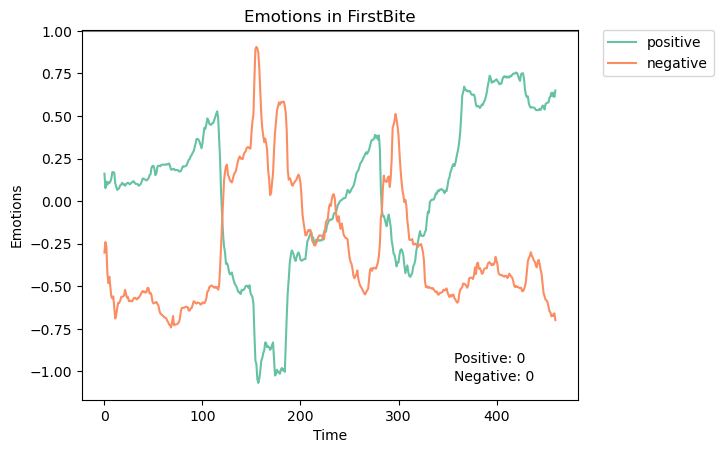

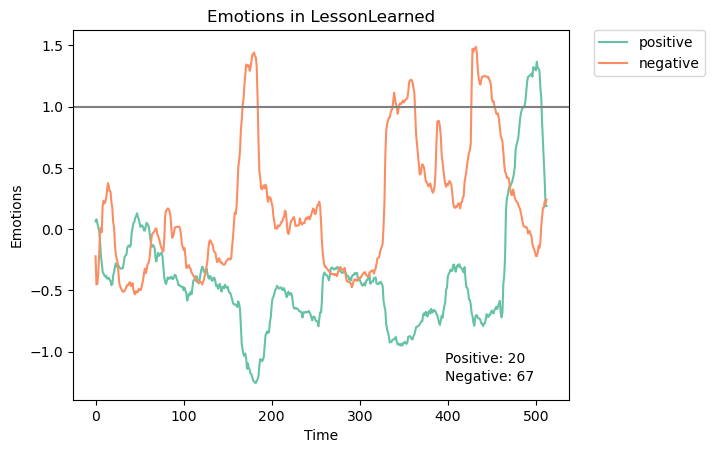

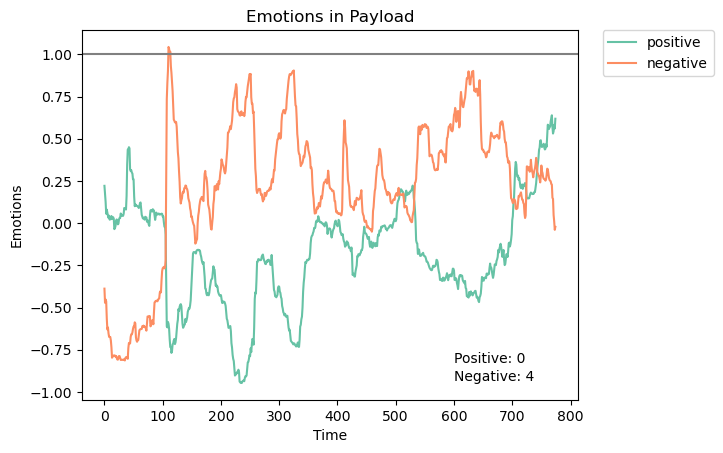

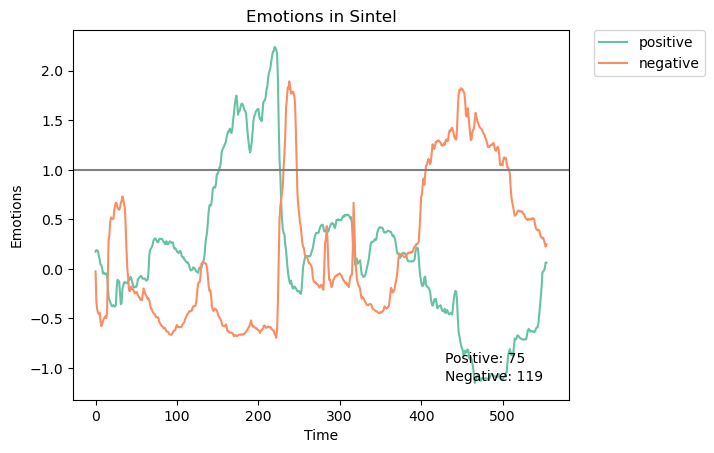

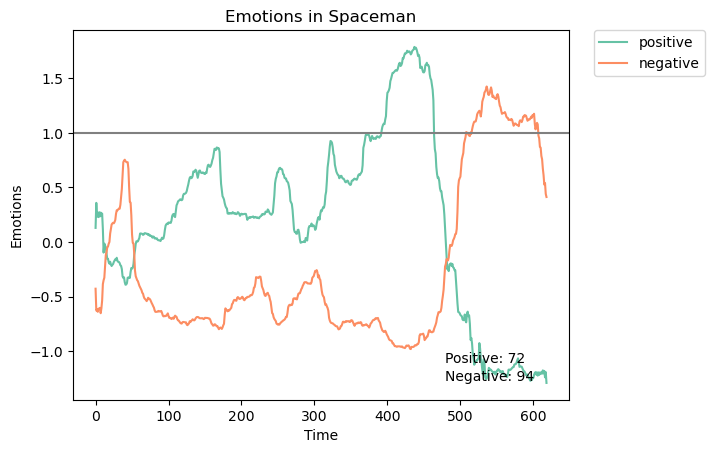

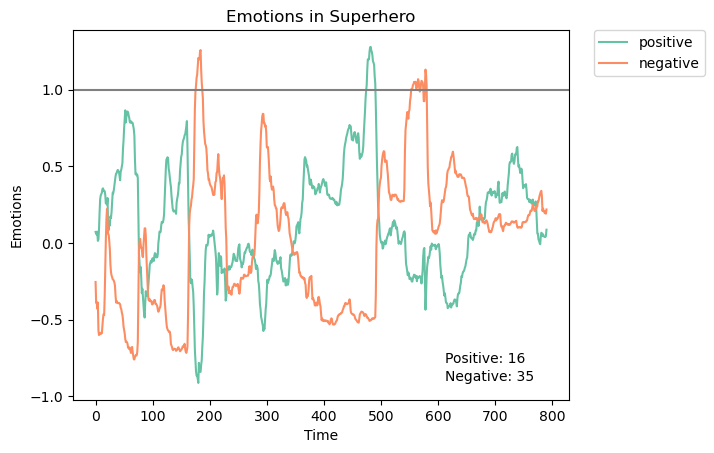

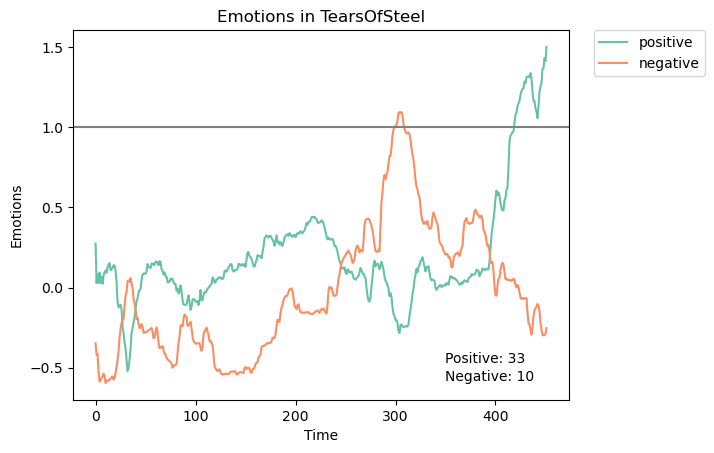

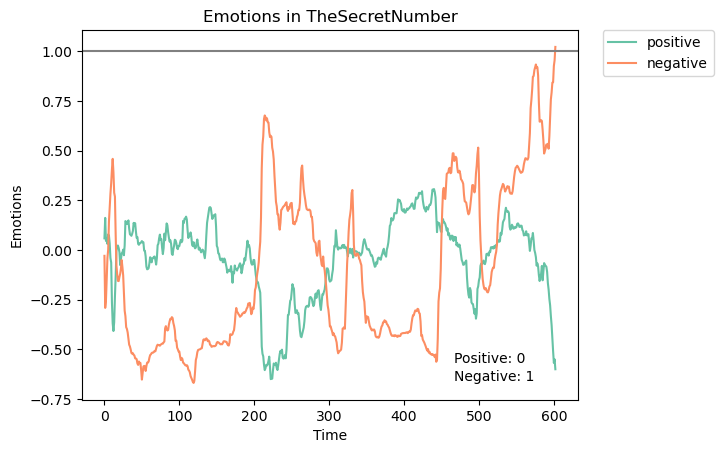

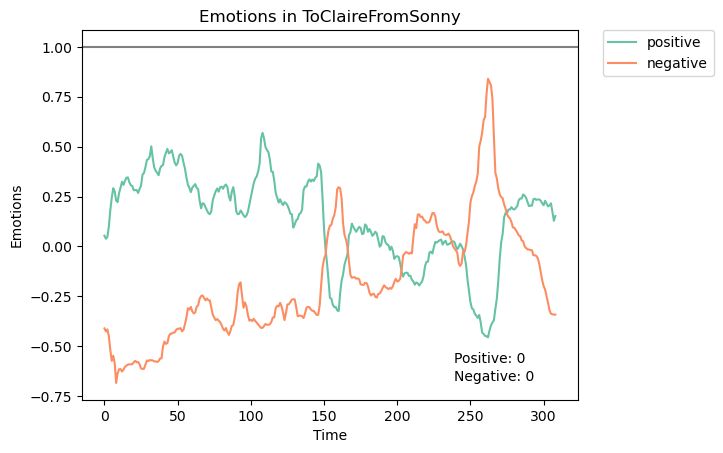

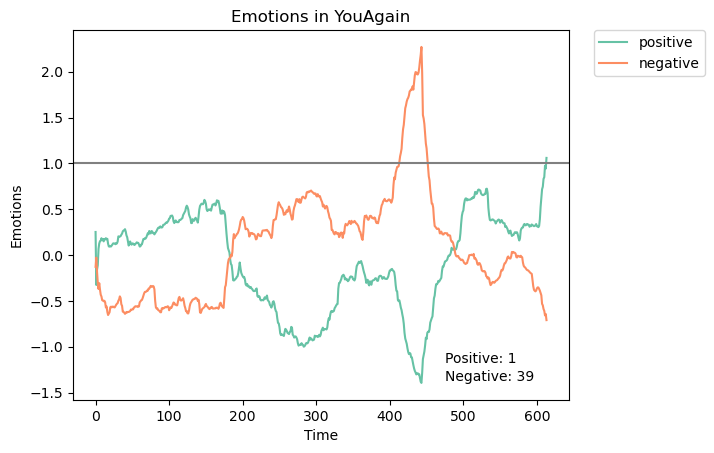

{'AfterTheRain': {1: {'positive': 0, 'negative': 30, 'All Movie': 382}}, 'BetweenViewings': {1: {'positive': 60, 'negative': 0, 'All Movie': 622}}, 'BigBuckBunny': {1: {'positive': 14, 'negative': 39, 'All Movie': 377}}, 'Chatter': {1: {'positive': 6, 'negative': 18, 'All Movie': 312}}, 'FirstBite': {1: {'positive': 0, 'negative': 0, 'All Movie': 461}}, 'LessonLearned': {1: {'positive': 20, 'negative': 67, 'All Movie': 513}}, 'Payload': {1: {'positive': 0, 'negative': 4, 'All Movie': 775}}, 'Sintel': {1: {'positive': 75, 'negative': 119, 'All Movie': 555}}, 'Spaceman': {1: {'positive': 72, 'negative': 94, 'All Movie': 619}}, 'Superhero': {1: {'positive': 16, 'negative': 35, 'All Movie': 791}}, 'TearsOfSteel': {1: {'positive': 33, 'negative': 10, 'All Movie': 452}}, 'TheSecretNumber': {1: {'positive': 0, 'negative': 1, 'All Movie': 603}}, 'ToClaireFromSonny': {1: {'positive': 0, 'negative': 0, 'All Movie': 309}}, 'YouAgain': {1: {'positive': 1, 'negative': 39, 'All Movie': 614}}}


In [431]:
def counting_points(movies, thresholds):
    """This function is used to count the number of points for each emotion in each movie."""
    count_pts = {}
    positive = ['Love', 'Regard', 'WarmHeartedness', 'Pride', 'Satisfaction', 'Happiness']
    negative = ['Sad', 'Anxiety', 'Fear', 'Guilt', 'Disgust', 'Anger']

    for movie in movies:
        count_pts[movie] = {}
        
        for thr in thresholds:
            count_pts[movie][thr] = {}

            # Reading the data
            labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
            data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
            data.columns = labels['Columns']

            emo_avg_positive = data[positive].mean(axis=1)
            emo_avg_negative = data[negative].mean(axis=1)
            
            # Counting the number of points for each emotion
            for emotion in ['positive', 'negative']:
                if emotion == 'positive':
                    number_points = len(emo_avg_positive[emo_avg_positive > thr])
                    positive_n = number_points
                else:
                    number_points = len(emo_avg_negative[emo_avg_negative > thr])
                    negative_n = number_points
                count_pts[movie][thr][emotion] = number_points
            
            count_pts[movie][thr]['All Movie'] = len(data)

            # plot the lineplot
            plt.plot(emo_avg_positive, label = 'positive', color = sns.palettes.color_palette("Set2", 8)[0])
            plt.plot(emo_avg_negative, label = 'negative', color = sns.palettes.color_palette("Set2", 8)[1])
            plt.axhline(y=thr, color='grey', linestyle='-')
            plt.xlabel('Time')
            plt.ylabel('Emotions')
            plt.title(f'Emotions in {movie}')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            # annotate the number of points
            plt.annotate(f'Positive: {positive_n}', xy=(0.750, 0.10), xycoords='axes fraction')
            plt.annotate(f'Negative: {negative_n}', xy=(0.750, 0.05), xycoords='axes fraction')
            plt.show()
    return count_pts

movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']
count_pts = counting_points(movies, [1])

print(count_pts)

In [432]:
emo_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSmean_withcontrol_results.csv')
emo_data.dropna(inplace=True)

df_all.rename(columns={'emotion': 'Emotion'}, inplace=True)


emo_data.head()

,Covariance Explained,P-value,Movie,LC,Region,bootstrap_round,Emotion,threshold
0,0.409000,0.046953,LessonLearned,1,ALL,0,positive,1.0
1,0.251699,0.003996,LessonLearned,2,ALL,0,positive,1.0
2,0.110802,0.077922,LessonLearned,3,ALL,0,positive,1.0
3,0.069793,0.574426,LessonLearned,4,ALL,0,positive,1.0
4,0.048219,0.177822,LessonLearned,5,ALL,0,positive,1.0


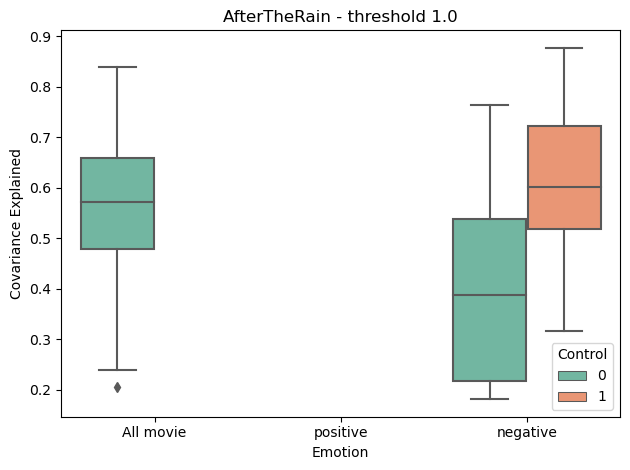

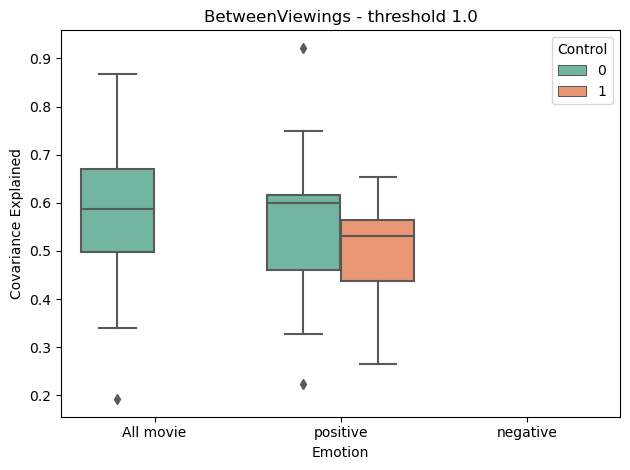

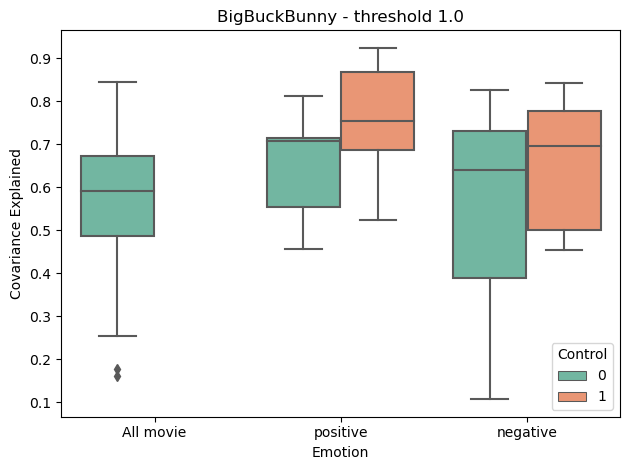

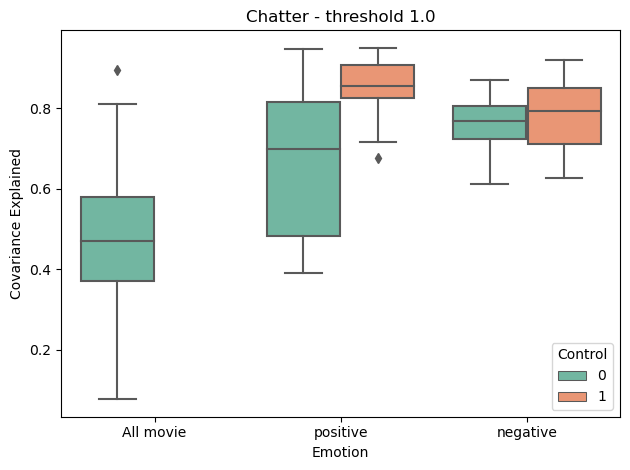

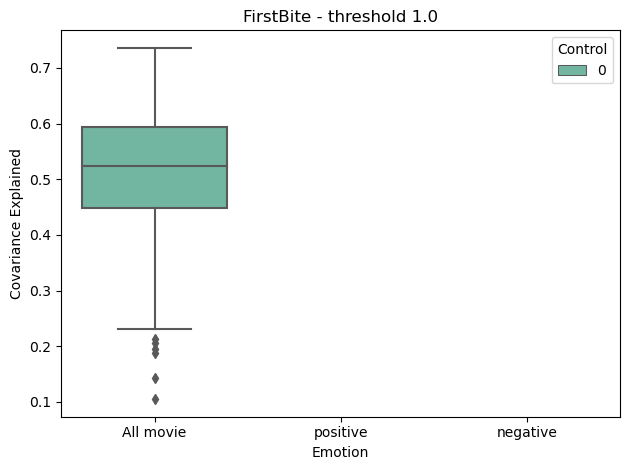

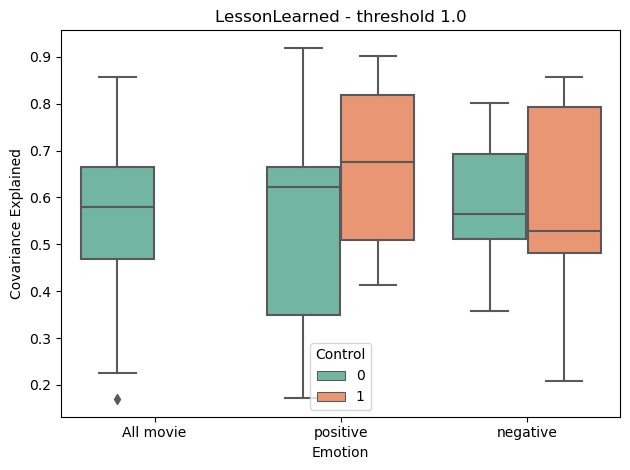

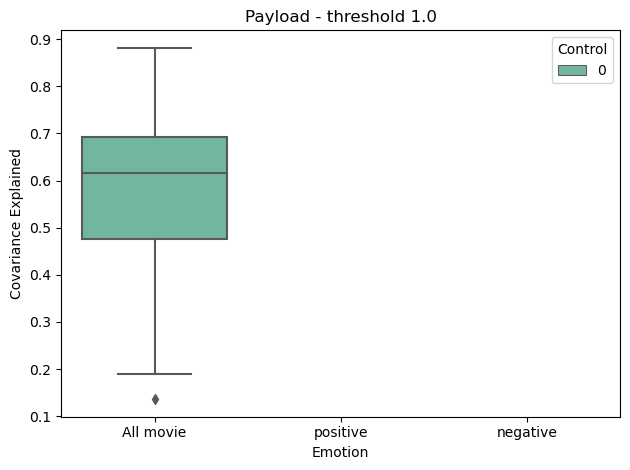

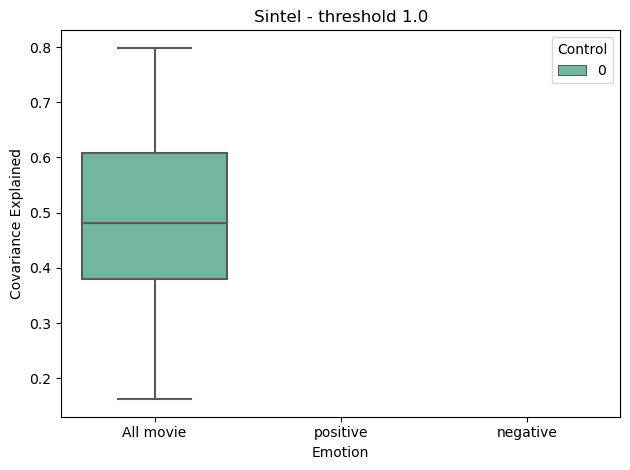

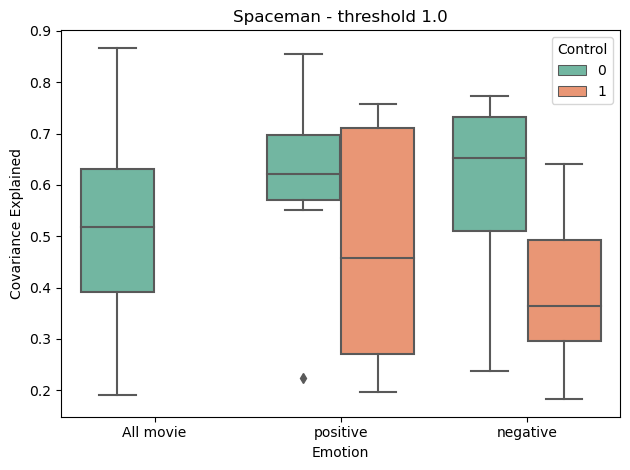

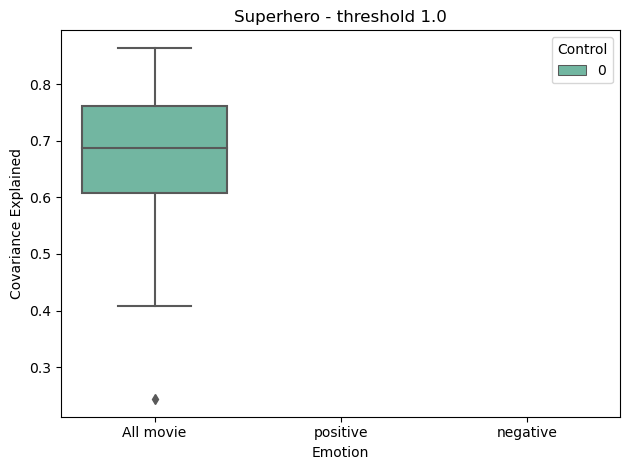

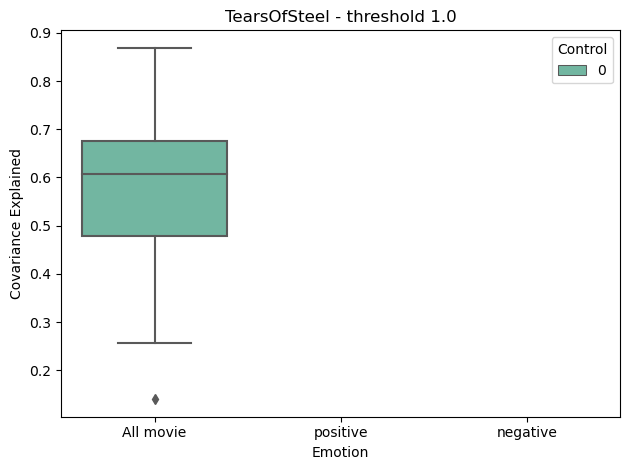

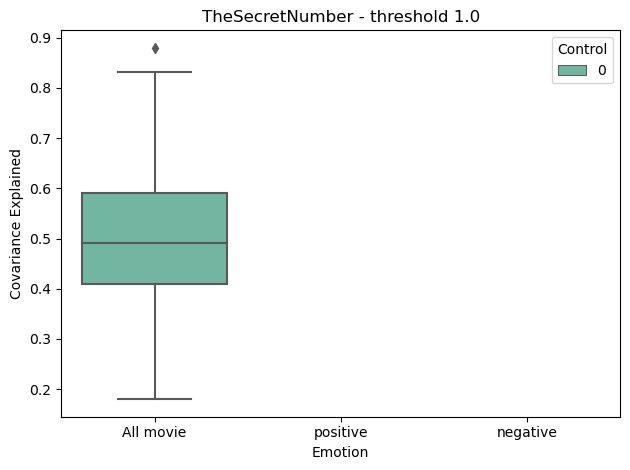

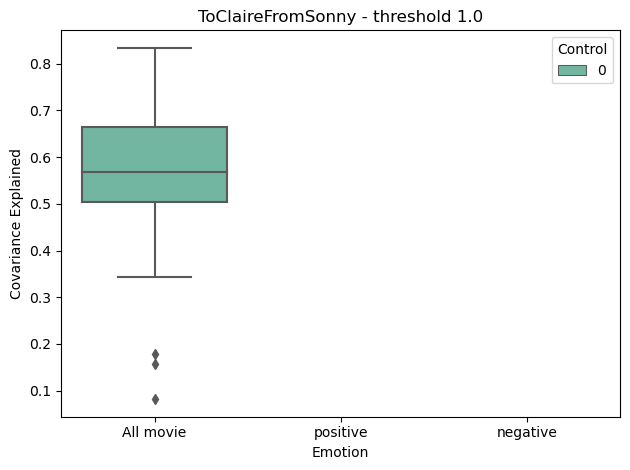

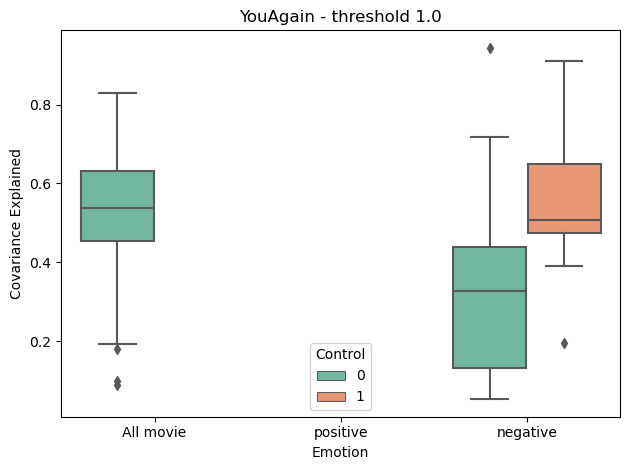

In [433]:
movie = 'Sintel'
thresholds = [1, 1.5, 2]

def retrieve_significant_data_mean(movie, all_emo_data, data_all_movie, count_pts, thresholds, emotions):

    # read the emotion data columns:        Movie Region bootstrap_round emotion Covariance Explained
    data_emo = all_emo_data
    significant = data_emo[data_emo['P-value'] < 0.05]
    significant = significant.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion', 'threshold']).sum()['Covariance Explained'].reset_index()
    significant['Control'] = significant['Emotion'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
    significant['Emotion'] = significant['Emotion'].apply(lambda x: x.split('_')[-1])

    # significant all movie
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()
    significant_all_movie['Control'] = 0

    # merge the three dataframes
    significant = pd.concat([significant, significant_all_movie], ignore_index=True)
    significant = significant[significant['Movie'] == movie]

    return significant

def plot_mean(movie, significant, data, emotions):
    # Define your thresholds
    thr = 1.0 
    palette = sns.color_palette("Set2", 8)

    # Filter data for the current threshold
    significant.loc[significant['Emotion'] == 'All movie', 'threshold'] = thr
    df_thr = significant[significant['threshold'] == thr]

    # Plot the boxplot in the i-th subplot
    sns.boxplot(x='Emotion', y='Covariance Explained', data=df_thr,  hue='Control', palette=palette, order=['All movie', 'positive', 'negative'])

    # set x labels as ['All movie', 'positive', 'negative']
    plt.xticks(np.arange(3), ['All movie', 'positive', 'negative'])
    plt.title(f'{movie} - threshold {thr}')


    plt.tight_layout()
    plt.show()

for movie in movies:
    emotions = ['positive', 'negative']
    significant = retrieve_significant_data_mean(movie, emo_data, df_all, count_pts, thresholds, emotions)
    plot_mean(movie, significant, data, emotions)

## Plot for the presentation of 16/11/2023

This is the official plot 

In [434]:
emotions = ['Happiness']
thresholds = [1, 1.5, 2]
for movie in ['Sintel', 'Superhero', 'TearsOfSteel', 'TheSecretNumber']:

    # read the emotion data columns:        Movie Region bootstrap_round emotion Covariance Explained
    data_emo = all_emo_data
    significant = data_emo[data_emo['P-value'] < 0.05]
    significant = significant.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()

    # read control
    significant_control = all_emo_control
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()

    # merge the two dataframes
    significant = pd.concat([significant, significant_control, significant_all_movie], axis = 0)
    significant = significant[significant['Movie'] == movie]

    # add a control column to the dataframe if emotion ends with control
    significant['Control'] = significant['Emotion'].apply(lambda x: 1 if x.split('_')[-1] == 'control' else 0)

    # add the number of points to the dataframe
    for emotion in emotions:
        significant.loc[significant['Emotion'] == emotion.split('_')[0], 'Number of points'] = count_pts[movie][thr][emotion]
    significant.loc[significant['Emotion'] == 'All movie', 'Number of points'] = count_pts[movie][thr]['All movie']

    # EMOTION PEAKS
    labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
    data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
    data.columns = labels['Columns']
    emotions = data_emo.emotion.unique()

    # PLOT
    palette = sns.color_palette("Set2", 8)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 1.25, box.height])
    box = ax2.get_position()
    ax2.set_position([box.x0 + 0.1, box.y0, box.width * 1, box.height])
    ax1.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax2.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

    palette_sns = {
        'Anxiety': sns.color_palette("Set2", 8)[3],
        'Anxiety_control': sns.color_palette("Set2", 8)[-1],
        'Sad': sns.color_palette("Set2", 8)[2],
        'Sad_control': sns.color_palette("Set2", 8)[-1],
        'Happiness': sns.color_palette("Set2", 8)[1],
        'Happiness_control': sns.color_palette("Set2", 8)[-1],
        'Love': sns.color_palette("Set2", 8)[0],
        'Love_control': sns.color_palette("Set2", 8)[-1],
        'All movie': sns.color_palette("Set2", 8)[5],
    }
    # plot the boxplot
    order_emotions = ['All Movie']
    for emotion in ['Happiness']:
        order_emotions.append(emotion)
        order_emotions.append(emotion + '_control')

    sns.boxplot(x = 'Emotion', y = 'Covariance Explained', order = order_emotions, data = significant, ax = ax1, palette = palette_sns)
    list_n = []
    for emo in order_emotions:
        n = significant[significant['Emotion'] == emo.split('_')[0]]['Number of points'].unique()
        if len(n) == 0:
            n = 0
        else:
            n = n[0]
        list_n.append(f'{emo}: {int(n)}')

    ax1.set_xticklabels(list_n, rotation=45, ha='right')
    # give colors to the x labels
    for i, emotion in enumerate(list_n):
        if emotion.split(':')[0] in emotions:
            ax1.get_xticklabels()[i].set_color(palette[list(emotions).index(emotion.split(':')[0])])
        else:
            ax1.get_xticklabels()[i].set_color('black')
    ax1.set_title(f'Emotion Peaks in {movie}')
    ax1.set_xlabel('Regions')
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

    list_emot = ['Happiness', 'All Movie']
    for emotion in list_emot:
        ax1.annotate(f'n = {int(n)}', xy=(list(list_emot).index(emotion), -0.25), xytext=(list(list_emot).index(emotion), 0.05), fontsize = 12)

    # plot the lineplot
    for i, emotion in enumerate(list_emot[0:-1]):
        print(emotion)

        n = significant[significant['Emotion'] == emotion]['Number of points'].unique()
        if len(n) == 0:
            n = 0
        else:
            n = n[0]
        plt.plot(data[emotion], label = emotion + f': {n}', color = palette[list(emotions).index(emotion)])

    ax2.set_title(f'Emotion Peaks in {movie}')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Emotions')
    ax2.axhline(y=1, color='grey', linestyle='-')
    ax2.legend()
    

    plt.show()

KeyError: 'Happiness'